## Micrograd scratchpad

Notes from Karpathy's micrograd walkthrough. Flow: build `Value` for scalar autograd -> visualize the graph -> manual vs automated backprop -> tiny MLP trained with GD.

https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Autograd scaffold
Minimal `Value` class for scalars with operator overloads, tanh/exp helpers, `backward`, and a toy chain to trace.

In [3]:
class Value:

    def __init__(self,data, _children = (), _op='',label=""):
        self.data=data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other) # lets you add constants
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad +=1.0*out.grad
            other.grad +=1.0*out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # ensures we can do 2 * Value
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        # derivative of x^n is n*x^(n-1) therefore we multiply with other * (self.data ** (other -1)) and out.grad which is the gradient from above, so local gradient times chain rule
        # where other is n and self.data is x
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        # derivative of e^x is e^x, therefore we multiply with out.data which is e^x and out.grad which is the gradient from above, so local gradient times chain rule
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d=e+c; d.label="d"
f = Value(-2.0, label="f")
L = d* f; L.label="L"
d._op

'+'

In [4]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr=({'rankdir':'LR'}))

    nodes,edges = trace(root)

    for n in nodes:
        uid=str(id(n))

        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape="record")

        if n._op:
            dot.node(name=uid+n._op,label=n._op)

            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    

    return dot

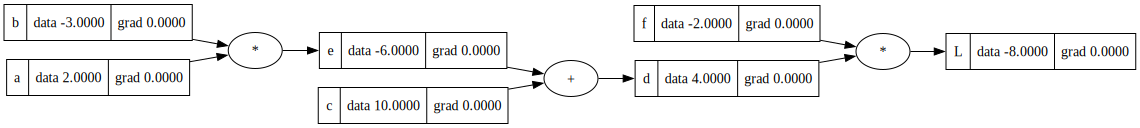

In [5]:
draw_dot(L)

### Tanh toy example
Scalar neuron with two inputs to visualize the graph before doing any backward passes.

In [6]:

# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()


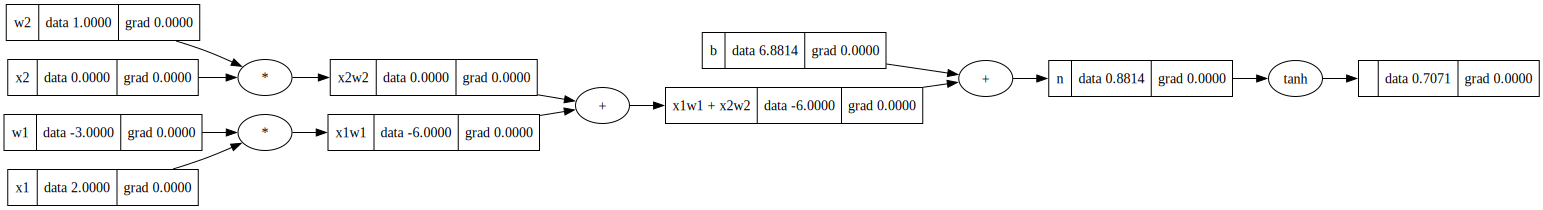

In [7]:
draw_dot(o)


### Manual backward check
Hand-compute gradients for the tanh neuron to sanity check signs and scales before trusting the autograd.

In [8]:
#manually backpropagation
o.grad = 1.0

# o = tanh(n)
# do/dn = 1- tanh(n)**2 = 1-o**2 

n.grad =1-o.data**2

b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0

x2w2.grad = x1w1x2w2.grad * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0

w1.grad = x1w1.grad * x1.data # dL/dw1 = dL/dx1w1 * dx1w1/dw1 hvor dx1w1/dw1 = x1.data
x1.grad = x1w1.grad * w1.data # motsatt som over, bare w1 data istedenfor x1 data

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data


### Stepping toward autograd
Call each `_backward` manually, then switch to `backward()` to confirm the graph wiring and gradient accumulation.

In [9]:
# Semi-Automated backpropagation
# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()


In [10]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
w1._backward()
x1._backward()
w2._backward()
x2._backward()


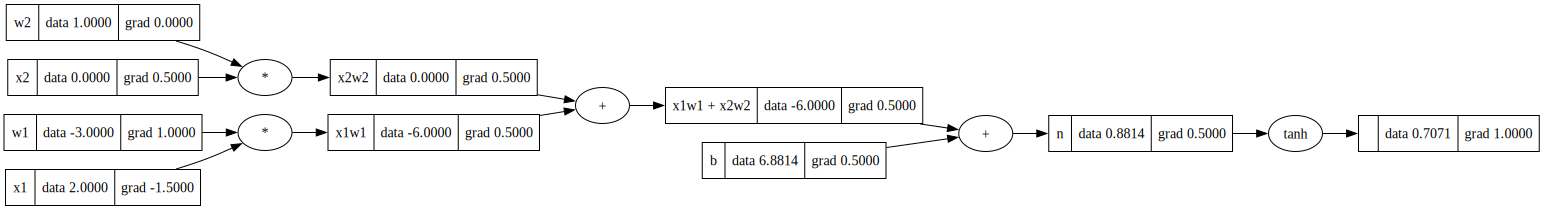

In [11]:
draw_dot(o)


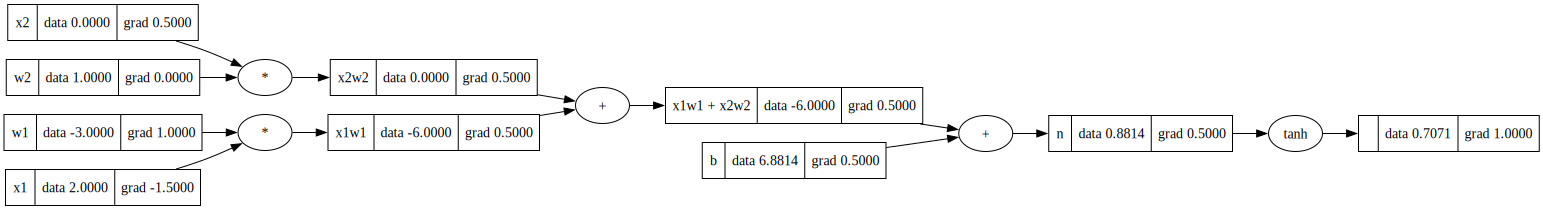

In [12]:
# Semi-Automated backpropagation
# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()

o.backward()

draw_dot(o)

### Gradient accumulation
`backward()` relies on each `_backward` using `+=` so shared nodes accumulate gradients; next cell shows the fix and verifies with a tiny graph.

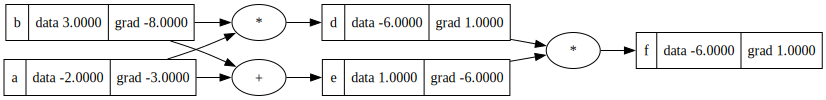

In [13]:
# Bug, fix is in _backward methods to use += instead of =, so we accumulate gradients properly 
a=Value(-2.0, label="a")
b=Value(3.0, label="b")
d=a*b ; d.label="d"
e = a+b ; e.label="e"
f = d * e ; f.label="f"
f.backward()
draw_dot(f)

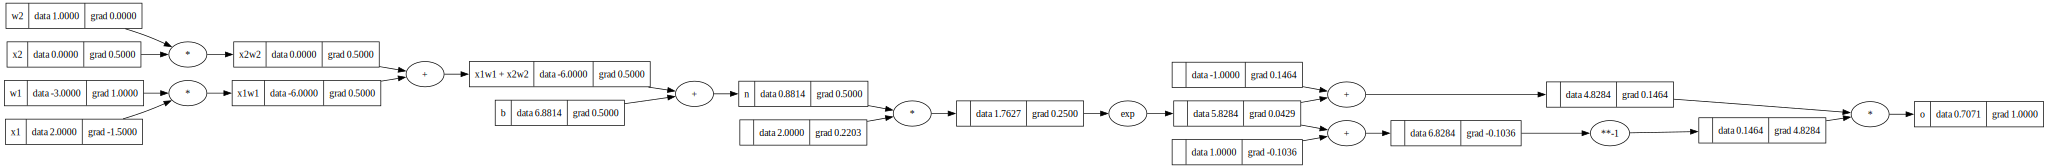

In [14]:
# Automated backprop without the tanh function but manually created
# inputs x1,x2


x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"


e = (2*n).exp()
o = (e-1)/(e+1)
o.label="o"
o.backward()

draw_dot(o)

### Tiny MLP
`Neuron`, `Layer`, and `MLP` reuse `Value` ops; activations are tanh and weights are small random scalars.

In [15]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0.0)
    
    def __call__(self, x):
        # weighted sum
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        # activation function
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs)>1 else outs[0]
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
    

x = [2.0,3.0,-1.0]
#3 inputs, 4 hidden neurons, 4 hidden neurons, 1 output neuron 
n = MLP(3,[4,4,1]) 
n(x)


Value(data=0.4856644532176896)

In [16]:
xs =[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] #targets

ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.4856644532176896), Value(data=0.47682341953147983), Value(data=-0.004893226236921253), Value(data=0.46486083308284004)]


### Simple training loop
Four toy examples, mean-squared loss, zero grads, backward, and SGD step at a fixed learning rate.

In [17]:
for i in range(30):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ytarget)**2 for yout, ytarget in zip(ypred, ys)), Value(0.0))
    #zero gradients
    for p in n.parameters():
        p.grad =0.0
    #backward pass, take derivative of loss which is the final output value object and call backward on it
    loss.backward()
    #update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(f"epoch {i} loss {loss.data}")

#check a weight
n.layers[0].neurons[0].w[0].data

n.layers[0].neurons[0].w[0].grad


#y pred
ypred = [n(x) for x in xs]
print(ypred)

epoch 0 loss 3.722159886318466
epoch 1 loss 2.82187769051171
epoch 2 loss 2.273536037929623
epoch 3 loss 1.5369141369709187
epoch 4 loss 0.9158326652445847
epoch 5 loss 0.596694875910835
epoch 6 loss 0.4269850443733527
epoch 7 loss 0.32631180012678584
epoch 8 loss 0.26100948008191693
epoch 9 loss 0.2157623260324799
epoch 10 loss 0.18281619817055828
epoch 11 loss 0.15789184856456362
epoch 12 loss 0.13845804635848738
epoch 13 loss 0.12293132949903572
epoch 14 loss 0.11027480036549803
epoch 15 loss 0.09978327089786529
epoch 16 loss 0.0909616600735394
epoch 17 loss 0.08345287630534214
epoch 18 loss 0.07699330660283435
epoch 19 loss 0.07138438376259022
epoch 20 loss 0.06647387286131909
epoch 21 loss 0.0621432276239667
epoch 22 loss 0.05829884779580145
epoch 23 loss 0.054865908175375164
epoch 24 loss 0.051783921862030555
epoch 25 loss 0.049003497035317256
epoch 26 loss 0.04648393038293477
epoch 27 loss 0.04419139685611518
epoch 28 loss 0.04209757095670881
epoch 29 loss 0.040178564661744576
[

# Single Neuron Architecture — Backprop Notes

This is the simplest possible **dense neuron** implemented from scratch using a computation graph and manual backprop. It is the core building block of a multilayer perceptron (MLP).

---

## Neuron Structure (Forward Pass)

The neuron does three operations:

1) Multiply each input by a weight  
2) Add the weighted inputs together and add a bias  
3) Apply a non-linear activation function

Mathematically:

    o = tanh(w1 * x1 + w2 * x2 + b)

Where:
- x1, x2 = inputs
- w1, w2 = learnable weights
- b = learnable bias
- o = output of the neuron

---

## Computation Graph

Breaking each step into nodes:<br>
x1w1      x2w2<br>
\        /<br>
\      /<br>
z_lin = (x1w1 + x2w2)<br>
|<br>
v<br>
n = z_lin + b    <– pre-activation<br>
|<br>
v<br>
o = tanh(n)      <– neuron output (treated as loss in tests)<br>

Each intermediate value (x1, w1, z_lin, etc.) is a `Value` object that stores:
- `data`: the current numerical value
- `grad`: the gradient flowing through that node
- `_backward()`: how to send gradient to its parents

---

## Backprop Intuition

To train the neuron, we ask:

> “If I nudge this value a little, how much does the output change?”

Gradient flow backward through the graph:

Look at the graph underneath

At each step:
- We take the gradient coming from the node above
- Multiply by the local slope of that operation
- Accumulate it into the parents (`+=`)

The end result is that each weight gets a gradient:
- w.grad tells how changing that weight would change the output

Then we can update:

    w = w - learning_rate * w.grad
    b = b - learning_rate * b.grad

---

## Why This Matters

This tiny example contains everything a neural network needs:

✔ weighted inputs  
✔ bias term  
✔ non-linearity  
✔ full gradient flow via chain rule  
✔ ability to learn with gradient descent  

Scaling this idea:
- More inputs → same weight pattern
- More neurons → duplicate the structure
- More layers → stack the pattern

This is **how all deep learning works** under the hood.

---

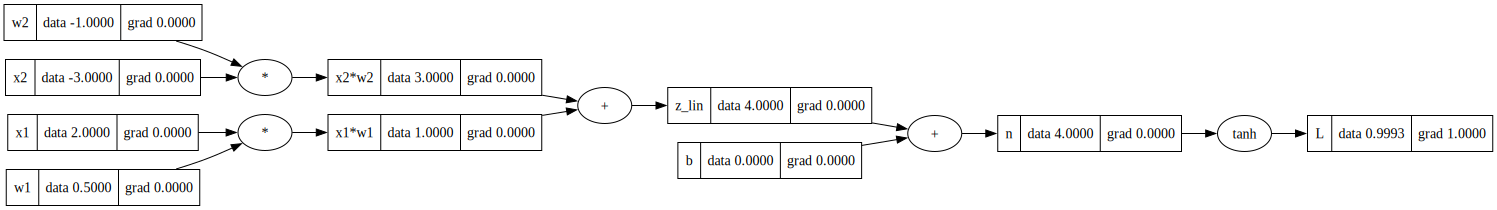

In [25]:
import math

# inputs
x1 = Value(2.0, label="x1")
x2 = Value(-3.0, label="x2")

# weights
w1 = Value(0.5, label="w1")
w2 = Value(-1.0, label="w2")

# bias
b = Value(0.0, label="b")

# forward pass of a dense neuron: z = x1*w1 + x2*w2 + b
x1w1 = x1 * w1;  x1w1.label = "x1*w1"
x2w2 = x2 * w2;  x2w2.label = "x2*w2"

z = x1w1 + x2w2; z.label = "z_lin"
n = z + b;       n.label = "n"      # pre-activation
o = n.tanh();    o.label = "o"      # activation output

# treat o as the "loss" L for now
L = o
L.label = "L"
L.grad = 1.0
o.grad = 1.0

dot = draw_dot(L)
dot

So now, calculate the gradient for each variable:
dL/dN = ??
dL/dZ = ??
dL/dB = ??
dL/dX1W1 = ??
dL/dX2W2 = ??
dL/dX1 = ??
dL/dW1 = ??
dL/dW2 = ??
dL/dX2 = ??



In [ ]:

n.grad =0.0
z.grad = 0.0
b.grad = 0.0
x1w1.grad = 0.0
x2w2.grad = 0.0
x1.grad = 0.0
w1.grad = 0.0
x2.grad = 0.0
w2.grad = 0.0


## 1. From L to n (through tanh)

We have:

    L = o
    o = tanh(n)

So:

    dL/dn = dL/do * do/dn

We set dL/dL = 1, so:

    dL/do = 1

The derivative of tanh is:

    do/dn = 1 - tanh(n)^2

But tanh(n) is just o, so:

    do/dn = 1 - o^2

Therefore:

    dL/dn = dL/do * (1 - o^2)
           = 1 * (1 - o^2)
           = (1 - o^2)

Why this makes sense:
- n is the input to tanh.
- If you change n a bit, tanh(n) changes according to its slope: (1 - tanh(n)^2).
- That slope tells how sensitive the output is to n.


## 2. From n to z and b (through addition)

We have:

    n = z + b

Treat n as a simple function of z and b:

    n(z, b) = z + b

Partial derivatives:

- dn/dz = 1
- dn/db = 1

Reason:
- If you increase z by 1 (keeping b fixed), n increases by 1.
- If you increase b by 1 (keeping z fixed), n also increases by 1.

Using chain rule:

    dL/dz = dL/dn * dn/dz
           = dL/dn * 1
           = dL/dn

    dL/db = dL/dn * dn/db
           = dL/dn * 1
           = dL/dn

So the “*1” comes from:
- The derivative of (z + b) w.r.t. z is 1.
- The derivative of (z + b) w.r.t. b is also 1.
Nothing scales the gradient at this step; it just passes through.


## 3. From z to x1w1 and x2w2 (through another addition)

We have:

    z = x1w1 + x2w2

Again:

    z(a, b) = a + b

So:

- dz/d(x1w1) = 1
- dz/d(x2w2) = 1

Chain rule:

    dL/d(x1w1) = dL/dz * dz/d(x1w1)
                = dL/dz * 1
                = dL/dz

    dL/d(x2w2) = dL/dz * dz/d(x2w2)
                = dL/dz * 1
                = dL/dz

Same idea: adding two things doesn’t scale either one, so each gets the full gradient from z.


## 4. From x1w1 to x1 and w1 (through multiplication)

We have:

    x1w1 = x1 * w1

Think of:

    y = x1 * w1

Derivatives:

- dy/dx1 = w1
- dy/dw1 = x1

Reason:
- If you fix w1 and nudge x1 by a little, y changes proportionally to w1.
- If you fix x1 and nudge w1, y changes proportionally to x1.

Chain rule:

    dL/dx1 = dL/d(x1w1) * d(x1w1)/dx1
           = dL/d(x1w1) * w1

    dL/dw1 = dL/d(x1w1) * d(x1w1)/dw1
           = dL/d(x1w1) * x1


## 5. From x2w2 to x2 and w2 (multiplication again)

Similarly:

    x2w2 = x2 * w2

Derivatives:

- d(x2w2)/dx2 = w2
- d(x2w2)/dw2 = x2

Chain rule:

    dL/dx2 = dL/d(x2w2) * d(x2w2)/dx2
           = dL/d(x2w2) * w2

    dL/dw2 = dL/d(x2w2) * d(x2w2)/dw2
           = dL/d(x2w2) * x2


## 6. Summary of gradient formulas

Symbolically:

- dL/dL   = 1
- dL/dn   = dL/do * (1 - o^2)
- dL/dz   = dL/dn * 1           (because n = z + b)
- dL/db   = dL/dn * 1
- dL/d(x1w1) = dL/dz * 1        (because z = x1w1 + x2w2)
- dL/d(x2w2) = dL/dz * 1
- dL/dx1  = dL/d(x1w1) * w1
- dL/dw1  = dL/d(x1w1) * x1
- dL/dx2  = dL/d(x2w2) * w2
- dL/dw2  = dL/d(x2w2) * x2

The “*1” terms are there because:
- When a variable appears as a simple sum like `n = z + b`, increasing z by 1 increases n by 1.
- The derivative of `a + b` with respect to `a` is 1, and with respect to `b` is also 1.
- So the gradient just passes straight through additions without scaling.


## 7. Numeric example (with the chosen values)

Forward:

- x1 = 2.0, x2 = -3.0
- w1 = 0.5, w2 = -1.0, b = 0.0

Compute:

- x1w1 = 2.0 * 0.5 = 1.0
- x2w2 = -3.0 * -1.0 = 3.0
- z = x1w1 + x2w2 = 4.0
- n = z + b = 4.0
- o = tanh(4.0) ≈ 0.9993
- L = o

Start with:

- dL/dL = 1
- so dL/do = 1

Step 1: through tanh

    dL/dn = dL/do * (1 - o^2)
          ≈ 1 * (1 - 0.9993^2)
          ≈ 0.00134

Step 2: through n = z + b

    dL/dz = dL/dn * 1 = 0.00134
    dL/db = dL/dn * 1 = 0.00134

Step 3: through z = x1w1 + x2w2

    dL/d(x1w1) = dL/dz * 1 = 0.00134
    dL/d(x2w2) = dL/dz * 1 = 0.00134

Step 4: through x1w1 = x1 * w1

    dL/dx1 = dL/d(x1w1) * w1
           = 0.00134 * 0.5
           ≈ 0.00067

    dL/dw1 = dL/d(x1w1) * x1
           = 0.00134 * 2.0
           ≈ 0.00268

Step 5: through x2w2 = x2 * w2

    dL/dx2 = dL/d(x2w2) * w2
           = 0.00134 * (-1.0)
           ≈ -0.00134

    dL/dw2 = dL/d(x2w2) * x2
           = 0.00134 * (-3.0)
           ≈ -0.00402


## 8. Final gradient table

- dL/dn   ≈ 0.00134
- dL/dz   ≈ 0.00134
- dL/db   ≈ 0.00134
- dL/d(x1w1) ≈ 0.00134
- dL/d(x2w2) ≈ 0.00134
- dL/dx1  ≈ 0.00067
- dL/dw1  ≈ 0.00268
- dL/dx2  ≈ -0.00134
- dL/dw2  ≈ -0.00402

This is the complete backpropagation for this simple tanh neuron, with explicit explanations of each step and why some multipliers are 1.